<a href="https://colab.research.google.com/github/NUELBUNDI/NLP-using-Python/blob/master/Twitter_Scrapping_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/twitter-location-analysis-c488c967a41f

https://datascienceparichay.com/article/get-data-from-twitter-api-in-python-step-by-step-guide/

https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d

https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d

In [ ]:
# Import Libraries
!pip install pycountry
!pip install langdetect
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
nltk.download('vader_lexicon')
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 4.2 MB/s 


In [ ]:
# import tweepy
import tweepy as tw

# your Twitter API key and API secret
my_api_key = "iDjxoyNxVPxULPV1f2OxH2F8C"
my_api_secret = "RlNU4qxJBBnJpItC6nXvHKeXCwdauQmKejfMgS1kiVGwih4g6v"

# authenticate
auth = tw.OAuthHandler(my_api_key, my_api_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [ ]:

# Define the search term and the date_since date as variables
#search_query1 = "ruto"
#search_query2 = "elections"
#search_query3 = "covid"
search_query1 = "moseskuria"
search_query2 = "gmomaize"
search_query3 = "maize"
search_query4 = "gmo"
search_query5 = "moseskuria"

In [ ]:
# get tweets from the API
tweets = tw.Cursor(api.search,
                   #geocode="-31.3096000,18.3570000,500km",° S, 37.9062° 1.2921° S, 36.8219
                   geocode="1.2921,36.8219,500km",
              q=search_query1 or search_query2 or search_query3 or search_query4 or search_query5,
              lang="en",
              since="2020-11-01").items(1000)




# tweepy.Cursor(api.search, q='cricket', geocode="-22.9122,-43.2302,1km").items(10)

# store the API responses in a list
tweets_copy = []
for tweet in tweets:
    tweets_copy.append(tweet)
    
print("Total Tweets fetched:", len(tweets_copy))

In [ ]:
import pandas as pd

# intialize the dataframe
tweets_df = pd.DataFrame()

# populate the dataframe
for tweet in tweets_copy:
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    tweets_df = tweets_df.append(pd.DataFrame({'user_name': tweet.user.name, 
                                               'user_location': tweet.user.location,\
                                               'user_description': tweet.user.description,
                                               'user_verified': tweet.user.verified,
                                               'date': tweet.created_at,
                                               'text': text, 
                                               'hashtags': [hashtags if hashtags else None],
                                               'source': tweet.source}))
    tweets_df = tweets_df.reset_index(drop=True)

# show the dataframe
tweets_df.head()

In [ ]:
tweets_df.tail()

In [ ]:
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: ',"",x)
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tweets_df["text"] = tweets_df.text.map(remove_rt).map(rt)
tweets_df["text"] = tweets_df.text.str.lower()
tweets_df.head(10)

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values
tweets_df[['polarity', 'subjectivity']] = tweets_df['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweets_df['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tweets_df.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tweets_df.loc[index, 'sentiment'] = "positive"
    else:
        tweets_df.loc[index, 'sentiment'] = "neutral"
        tweets_df.loc[index, 'neg'] = neg
        tweets_df.loc[index, 'neu'] = neu
        tweets_df.loc[index, 'pos'] = pos
        tweets_df.loc[index, 'compound'] = comp
tweets_df.head(10)

In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tweets_df_negative = tweets_df[tweets_df["sentiment"]=="negative"]
tweets_df_positive = tweets_df[tweets_df["sentiment"]=="positive"]
tweets_df_neutral = tweets_df[tweets_df["sentiment"]=="neutral"]

In [ ]:
def count_values_in_column(data,feature):
     total=data.loc[:,feature].value_counts(dropna=False)
     percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
     return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tweets_df,"sentiment")

,Total,Percentage
neutral,63,100.0


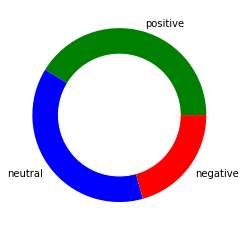

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tweets_df,"sentiment")
names = pichart.index
size=pichart['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
#Function to Create Wordcloud
def create_wordcloud(text):
     mask = np.array(Image.open("star.png"))
     stopwords = set(STOPWORDS)
     wc = WordCloud(background_color="white",
     mask = mask,
     max_words=3000,
     stopwords=stopwords,
     repeat=True)
     wc.generate(str(text))
     wc.to_file("wc.png")
     print("Word Cloud Saved Successfully")
     path="wc.png"
     display(Image.open(path))

Word Cloud Saved Successfully


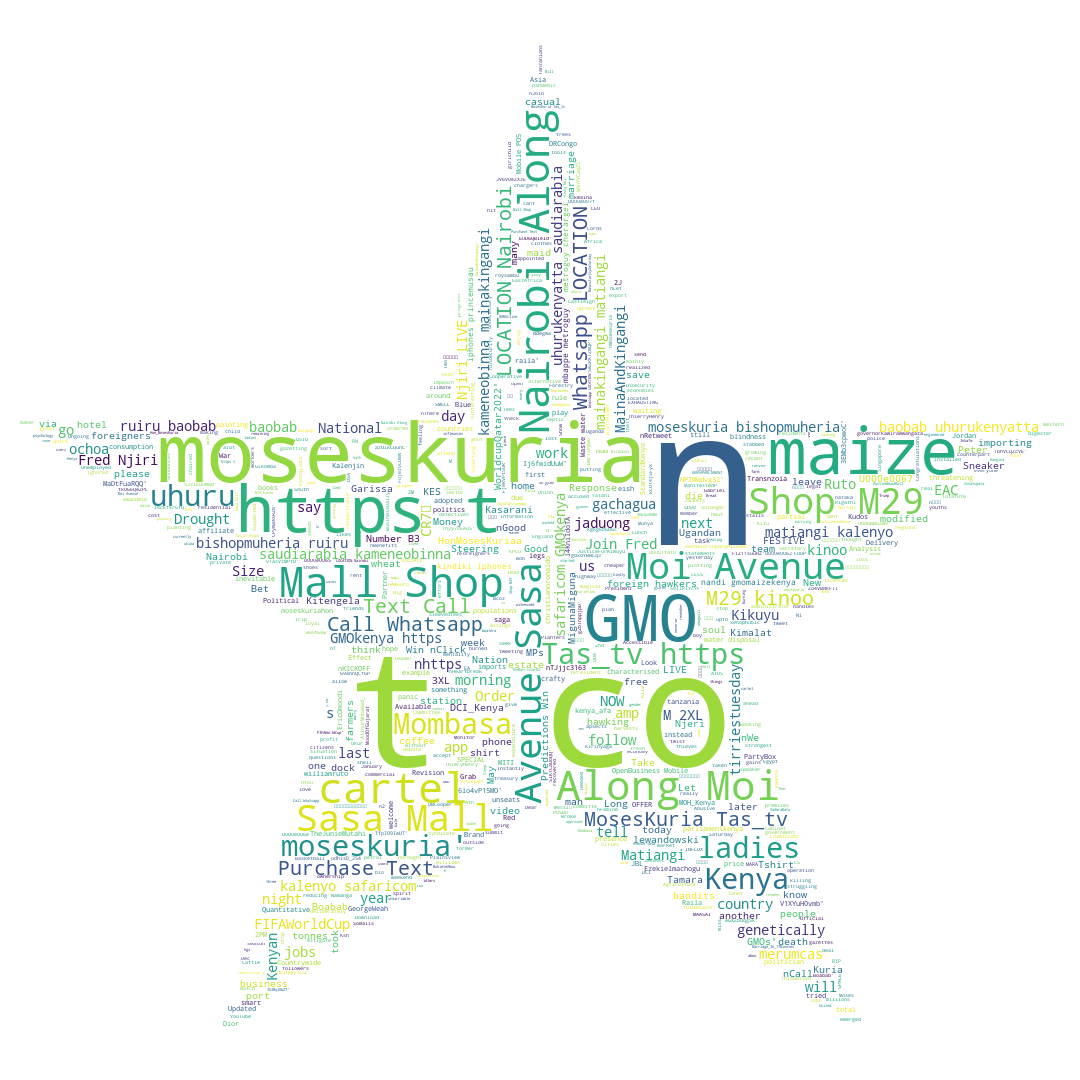

In [ ]:
#Creating wordcloud for all tweets
create_wordcloud(tweets_df["text"].values)

Word Cloud Saved Successfully


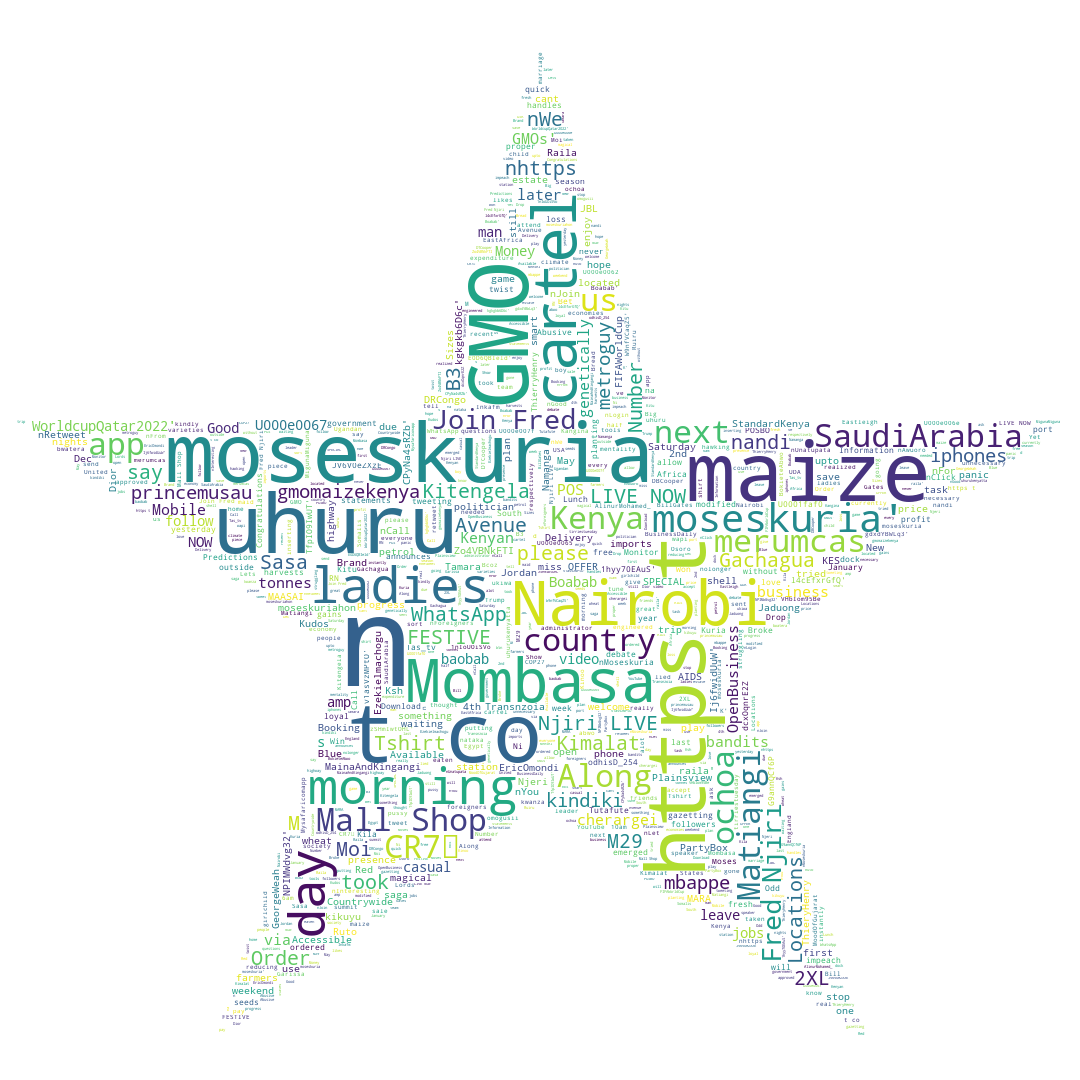

In [ ]:
#Creating wordcloud for positive sentiment
create_wordcloud(tweets_df_positive["text"].values)

Word Cloud Saved Successfully


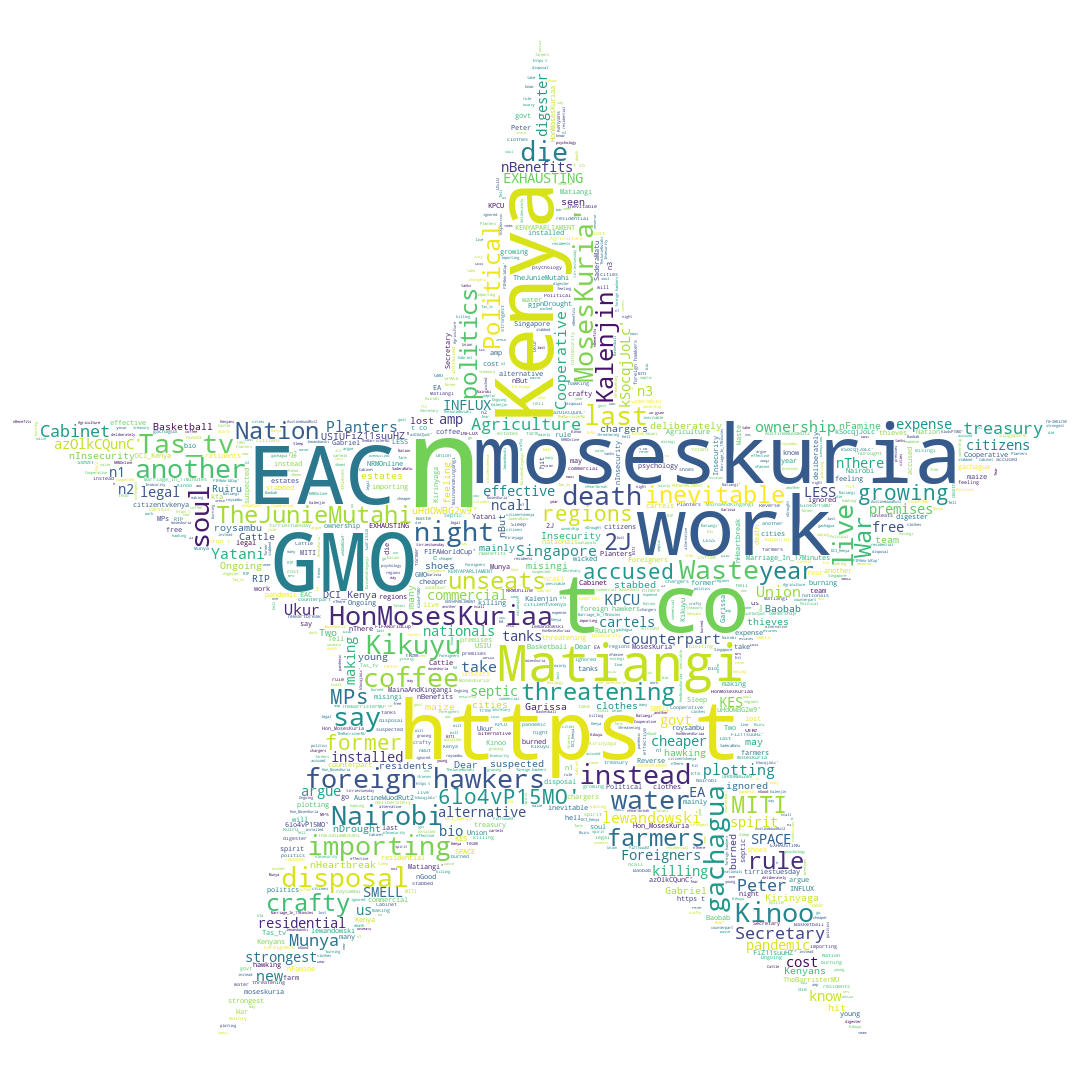

In [ ]:
#Creating wordcloud for negative sentiment
create_wordcloud(tweets_df_negative["text"].values)